In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydot
from keras.utils.vis_utils import plot_model

In [2]:
data = np.load("data.npy")

In [3]:
X = data[:,:22500]
Y = data[:,22500]
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [6]:
del data

In [4]:
base_model = tf.keras.applications.EfficientNetB5(
    include_top=False, 
    weights='imagenet',
    input_shape= (150,150,3)
)

In [5]:
base_model.trainable = True

In [9]:
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0

In [6]:
def resNet(x, shape = 256, drate = 0.2):
    y = tf.keras.layers.Dense(shape, activation = "relu")(x)
    z = tf.keras.layers.Dropout(drate)(y)
    q = tf.keras.layers.Dense(shape)(z)
    w = tf.keras.layers.Add()([q,x])
    w = tf.keras.layers.Activation("relu") (w)
    return w

In [7]:
inputs = tf.keras.Input(shape=(22500,))
x=tf.keras.layers.Reshape((150,150,1),input_shape = (22500,))(inputs)
x = tf.keras.layers.concatenate([x,x,x], axis = -1)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip()(x)
x = tf.keras.layers.Rescaling(scale=1./255)(x)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256 , activation = 'relu')(x)
for _ in range(10):
    x = resNet(x , shape = 256, drate = 0.3)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)

model = tf.keras.Model(inputs, outputs)

In [8]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999),
        loss=tf.keras.losses.MeanSquaredError(),
        run_eagerly=False,
        metrics=[tf.keras.metrics.mean_squared_error, tf.keras.metrics.RootMeanSquaredError(name = "rmse")]
    )

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./cp.ckpt",
    monitor='val_loss',
    verbose=1, 
    save_best_only=False,
    save_weights_only=True,
    save_freq= 564
)

In [14]:
lr_rd = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_rmse',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001
)

In [13]:

history  = model.fit(
    X[:20000,:],
    Y[:20000],
    validation_split= 0.1,
    verbose = 2,
    epochs=200,
    callbacks=[model_checkpoint_callback, lr_rd]
)

2022-04-09 16:53:52.534131: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-04-09 16:53:54.155658: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-04-09 16:53:55.333654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-04-09 16:54:17.440087: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


563/563 - 238s - loss: 0.0769 - mean_squared_error: 0.0769 - rmse: 0.2773 - val_loss: 3.7164e-04 - val_mean_squared_error: 3.7164e-04 - val_rmse: 0.0193
Epoch 2/200

Epoch 00002: saving model to ./cp.ckpt
563/563 - 210s - loss: 3.1095e-04 - mean_squared_error: 3.1095e-04 - rmse: 0.0176 - val_loss: 2.1531e-04 - val_mean_squared_error: 2.1531e-04 - val_rmse: 0.0147
Epoch 3/200

Epoch 00003: saving model to ./cp.ckpt
563/563 - 209s - loss: 2.4020e-04 - mean_squared_error: 2.4020e-04 - rmse: 0.0155 - val_loss: 2.1800e-04 - val_mean_squared_error: 2.1800e-04 - val_rmse: 0.0148
Epoch 4/200

Epoch 00004: saving model to ./cp.ckpt
563/563 - 209s - loss: 2.2633e-04 - mean_squared_error: 2.2633e-04 - rmse: 0.0150 - val_loss: 2.1456e-04 - val_mean_squared_error: 2.1456e-04 - val_rmse: 0.0146
Epoch 5/200

Epoch 00005: saving model to ./cp.ckpt
563/563 - 208s - loss: 2.2309e-04 - mean_squared_error: 2.2309e-04 - rmse: 0.0149 - val_loss: 2.1185e-04 - val_mean_squared_error: 2.1185e-04 - val_rmse: 0.

In [14]:
import pandas as pd
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

In [9]:
model.load_weights("./cp.ckpt")

In [13]:
model.save('Deeplense_Specific_III' , save_format = 'h5')

C:\Users\cdipt\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [9]:
history

,loss,mean_squared_error,rmse,val_loss,val_mean_squared_error,val_rmse,lr
0,0.076898,0.076898,0.277305,0.000372,0.000372,0.019278,1.000000e-03
1,0.000311,0.000311,0.017634,0.000215,0.000215,0.014674,1.000000e-03
2,0.000240,0.000240,0.015498,0.000218,0.000218,0.014765,1.000000e-03
3,0.000226,0.000226,0.015044,0.000215,0.000215,0.014648,1.000000e-03
4,0.000223,0.000223,0.014936,0.000212,0.000212,0.014555,1.000000e-03
...,...,...,...,...,...,...,...
195,0.000030,0.000030,0.005499,0.000044,0.000044,0.006633,7.450581e-12
196,0.000031,0.000031,0.005524,0.000044,0.000044,0.006607,3.725291e-12
197,0.000030,0.000030,0.005518,0.000044,0.000044,0.006619,3.725291e-12
198,0.000030,0.000030,0.005521,0.000044,0.000044,0.006651,3.725291e-12


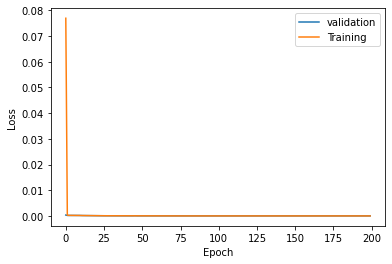

In [13]:

history = pd.read_csv("history.csv", )

plt.plot(np.array(range(0,200)) , np.array(history["val_mean_squared_error"]) , label = "validation")
plt.plot(np.array(range(0,200)) , np.array(history["mean_squared_error"]) , label = "Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

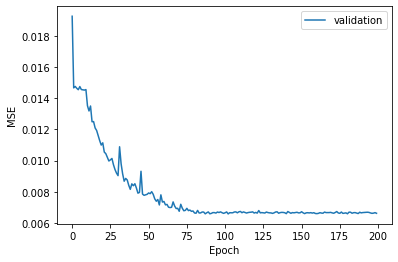

In [14]:
plt.plot(np.array(range(0,200)) , np.array(history["val_rmse"]) , label = "validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

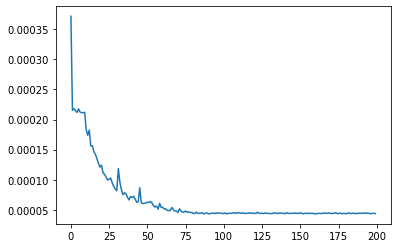

In [7]:
plt.plot(np.array(range(0,200)) , np.array(history["val_mean_squared_error"]))

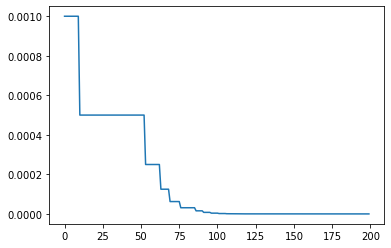

In [35]:
plt.plot(np.array(range(0,200)) , np.array(history["lr"]))